In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# figures inline, ignore warnings, setting visualisation style, standardisation
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore") 
sns.set()

# algo libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# evaluation libraries
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score

In [2]:
# load datasets
train_proc=pd.read_csv("train_proc.csv")
test_proc = pd.read_csv("test_proc.csv")

In [3]:
# splitting from training and validation data
X = train_proc.drop("Survived", axis =1)
y = train_proc['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [23]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.551881,1,0,-0.726134,False,True,True,False,True,False,True,False,False
1,0.768879,1,0,2.353815,False,False,False,False,False,False,False,True,False
2,-0.221691,0,0,-0.693667,False,True,False,False,True,True,False,False,False
3,0.521236,1,0,1.479214,False,False,False,False,True,False,False,True,False
4,0.521236,0,0,-0.687655,False,True,True,False,True,False,True,False,False


In [24]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Random forest algorithm

In [4]:
# grid search CV for model optimisation
rf_model = RandomForestClassifier(random_state=0)
param_dist = {'max_depth': [4,5,6],
              'bootstrap': [True, False],
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(rf_model, param_dist, cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_) # Get the best estimator from the grid search
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomForestClassifier(max_depth=6, max_features=None, random_state=0)
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': None}
0.828298017771702


In [5]:
# model with best parameters
rf_model_best = RandomForestClassifier(criterion = 'entropy', max_features = 'sqrt', max_depth = 5, random_state = 100)

In [6]:
# finding optimised no. of estimators
rf_model_best.set_params(warm_start=True, oob_score=True)
accuracy_rate = []
for i in range(30,150):     
    rf_model_best.set_params(n_estimators=i)
    rf_model_best.fit(X_train, y_train)
    accuracy_rate.append(rf_model_best.oob_score_)

Text(0, 0.5, 'Accuracy Rate')

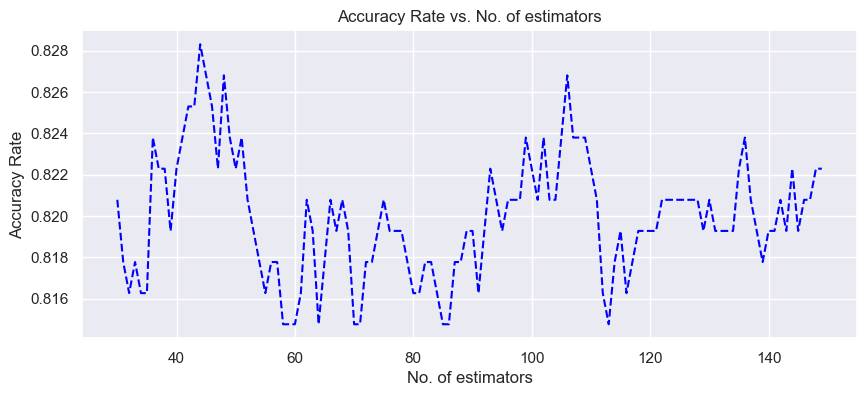

In [7]:
plt.figure(figsize=(10,4))
plt.plot(range(30,150),accuracy_rate,color='blue', linestyle='dashed')
plt.title('Accuracy Rate vs. No. of estimators')
plt.xlabel('No. of estimators')
plt.ylabel('Accuracy Rate')

In [8]:
# training the model
rf_model_best.set_params(n_estimators=60, oob_score=False, warm_start=False)
rf_model_best.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=60,
                       random_state=100)

### Evaluation parameters

In [9]:
predictions = rf_model_best.predict(X_test)
print(f'Training score : {rf_model_best.score(X_train,y_train)}')
print(f'Testing score : {rf_model_best.score(X_test,y_test)}')
print(f'OOB score :  {rf_model_best.oob_score_}')

Training score : 0.8539156626506024
Testing score : 0.8383233532934131
OOB score :  0.822289156626506


In [10]:
# confusion matrix
cm = confusion_matrix(y_test,predictions)
confusion_matrix(y_test,predictions)

array([[99,  6],
       [21, 41]], dtype=int64)

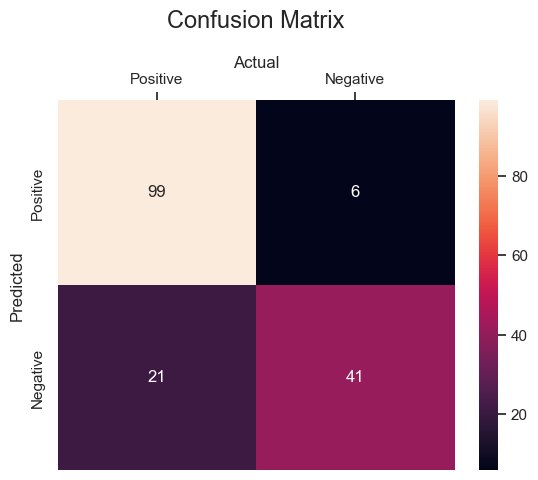

In [11]:
sns.heatmap(cm, 
            annot=True,
            fmt="d", 
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Predicted')
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.gca().xaxis.tick_top()
plt.xlabel('Actual')
plt.show()

In [12]:
# roc-auc curve
y_pred_prob = rf_model_best.predict_proba(X_test)[:,1]
fpr_dt,tpr_dt,threshold=roc_curve(y_test,y_pred_prob)
roc_auc_dt = auc(fpr_dt,tpr_dt)

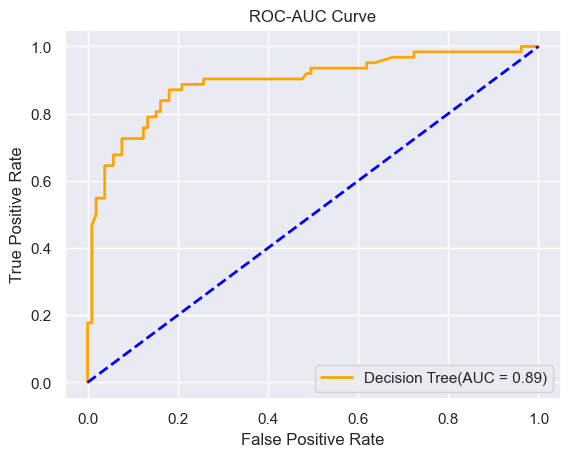

In [13]:
plt.figure()
plt.plot(fpr_dt,tpr_dt,color='orange',lw=2,label=f'Decision Tree(AUC = {roc_auc_dt:.2f})')
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],color='blue',lw=2,linestyle='--')

In [14]:
# classification report
report = classification_report(y_test,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       105
           1       0.87      0.66      0.75        62

    accuracy                           0.84       167
   macro avg       0.85      0.80      0.82       167
weighted avg       0.84      0.84      0.83       167



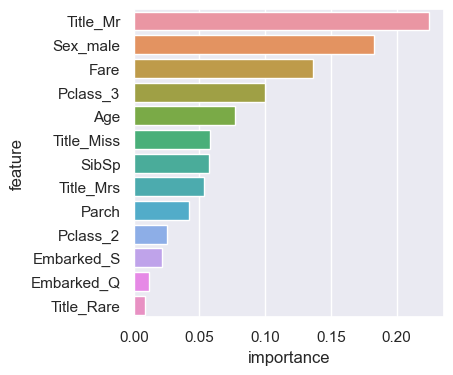

In [15]:
# features importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model_best.feature_importances_})
feature_rank = feature_rank.sort_values('importance', ascending = False)
plt.figure(figsize=(4,4))
sns.barplot(y = 'feature', x = 'importance', data = feature_rank);

In [16]:
feature_rank['cumsum'] = feature_rank['importance'].cumsum() * 100
feature_rank

,feature,importance,cumsum
10,Title_Mr,0.224666,22.466551
6,Sex_male,0.182924,40.758931
3,Fare,0.136460,54.404954
5,Pclass_3,0.099812,64.386110
0,Age,0.077334,72.119548
9,Title_Miss,0.058226,77.942197
1,SibSp,0.057630,83.705179
11,Title_Mrs,0.053626,89.067828
2,Parch,0.041767,93.244567
4,Pclass_2,0.025672,95.811771


In [17]:
# Adaboost classifier
base_model = DecisionTreeClassifier()
boost_model = AdaBoostClassifier(base_model, n_estimators=60, random_state=10)
boost_model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=60,
                   random_state=10)

In [18]:
# evaluation for adaboost classifier
predictions = boost_model.predict(X_test)
print("Accuracy Score : ")
print(accuracy_score(y_test,predictions))
print()
print("Confusion Matrix : ")
print(confusion_matrix(y_test,predictions))
print()
print("Classification report : ")
print(classification_report(y_test, predictions))
print()
print("Roc-Auc curve : ")
print(roc_auc_score(y_test, boost_model.predict_proba(X_test)[:,1]))

Accuracy Score : 
0.8203592814371258

Confusion Matrix : 
[[96  9]
 [21 41]]

Classification report : 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       105
           1       0.82      0.66      0.73        62

    accuracy                           0.82       167
   macro avg       0.82      0.79      0.80       167
weighted avg       0.82      0.82      0.82       167


Roc-Auc curve : 
0.8115207373271891


In [22]:
# predictions on test data
predictions = rf_model_best.predict(test_proc)

# creating dataframe of test predictions with Passenger Id, uncomment after loading test file with Passenger Id
# prediction_df = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions})

# Save the predictions to a CSV file, uncomment to save file
# prediction_df.to_csv('prediction.csv', index=False)